# Neural Networks: Multiple Features and Hidden Layers
This notebook demonstrates an artificial neural network with a hidden layer and multiple features as inputs. The data set regards the passengers on the Titanic and the goal is to predict survival. This data is pulled from Kaggle.com.

In [1]:
# import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing
The following downloads the Titanic data set then performs some preprocessing. This includes normalizing the features, dropping some of the columns that are more difficult to numerically encode, and creating some dummy variables for the categorical data columns. 

In [2]:
# download the data from a github repository
# pulled from Kaggle (12/18/18), https://www.kaggle.com/c/titanic/data
url_train = "https://raw.githubusercontent.com/prof-groff/deep-learning/master/data/titanic/train.csv"
url_test = "https://raw.githubusercontent.com/prof-groff/deep-learning/master/data/titanic/test.csv"

# load data and concatenate into one dataframe so it can all be normalized uniformly
train = pd.read_csv(url_train)
test = pd.read_csv(url_test)
titanic = pd.concat([train, test], keys=['train', 'test'], sort=False)
print(titanic.shape)
display(titanic.head(5)) # display is prettier than print

(1309, 12)


PassengerId  Survived  Pclass  \
train 0            1       0.0       3   
      1            2       1.0       1   
      2            3       1.0       3   
      3            4       1.0       1   
      4            5       0.0       3   

                                                      Name     Sex   Age  \
train 0                            Braund, Mr. Owen Harris    male  22.0   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
      2                             Heikkinen, Miss. Laina  female  26.0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
      4                           Allen, Mr. William Henry    male  35.0   

         SibSp  Parch            Ticket     Fare Cabin Embarked  
train 0      1      0         A/5 21171   7.2500   NaN        S  
      1      1      0          PC 17599  71.2833   C85        C  
      2      0      0  STON/O2. 3101282   7.9250   NaN        S  
      3      1      0            113803  53.1000  C123        S  
      4      0      0            373450   8.0500   NaN        S

In [3]:
# add some dummy variables for catigorical data (NaNs are ignored)
dummy_fields = ['Sex', 'Embarked','Pclass']
for each in dummy_fields:
    dummies = pd.get_dummies(titanic[each], prefix=each, drop_first=False)
    titanic = pd.concat([titanic, dummies], axis=1)
display(titanic.head(5))

PassengerId  Survived  Pclass  \
train 0            1       0.0       3   
      1            2       1.0       1   
      2            3       1.0       3   
      3            4       1.0       1   
      4            5       0.0       3   

                                                      Name     Sex   Age  \
train 0                            Braund, Mr. Owen Harris    male  22.0   
      1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
      2                             Heikkinen, Miss. Laina  female  26.0   
      3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
      4                           Allen, Mr. William Henry    male  35.0   

         SibSp  Parch            Ticket     Fare Cabin Embarked  Sex_female  \
train 0      1      0         A/5 21171   7.2500   NaN        S           0   
      1      1      0          PC 17599  71.2833   C85        C           1   
      2      0      0  STON/O2. 3101282   7.9250   NaN        S           1   
      3      1      0            113803  53.1000  C123        S           1   
      4      0      0            373450   8.0500   NaN        S           0   

         Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
train 0         1           0           0           1         0         0   
      1         0           1           0           0         1         0   
      2         0           0           0           1         0         0   
      3         0           0           0           1         1         0   
      4         1           0           0           1         0         0   

         Pclass_3  
train 0         1  
      1         0  
      2         1  
      3         0  
      4         1

In [4]:
# print out the column headings
print(titanic.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'Sex_female' 'Sex_male' 'Embarked_C'
 'Embarked_Q' 'Embarked_S' 'Pclass_1' 'Pclass_2' 'Pclass_3']


In [5]:
# drop some of the columns
fields_to_drop = ['Name', 'Pclass', 'Sex', 'Ticket', 
                  'Cabin', 'Embarked']
titanic = titanic.drop(fields_to_drop, axis=1)
display(titanic.head(5))

PassengerId  Survived   Age  SibSp  Parch     Fare  Sex_female  \
train 0            1       0.0  22.0      1      0   7.2500           0   
      1            2       1.0  38.0      1      0  71.2833           1   
      2            3       1.0  26.0      0      0   7.9250           1   
      3            4       1.0  35.0      1      0  53.1000           1   
      4            5       0.0  35.0      0      0   8.0500           0   

         Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
train 0         1           0           0           1         0         0   
      1         0           1           0           0         1         0   
      2         0           0           0           1         0         0   
      3         0           0           0           1         1         0   
      4         1           0           0           1         0         0   

         Pclass_3  
train 0         1  
      1         0  
      2         1  
      3         0  
      4         1

In [6]:
# scale continuous variable features to between zero and one using max/min scaling
quant_features = ['Age', 'SibSp', 'Parch', 'Fare']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    xmin, xmax = titanic[each].min(), titanic[each].max()
    scaled_features[each] = [xmin, xmax]
    titanic.loc[:, each] = (titanic[each] - xmin)/(xmax - xmin)

# replace NaN with zero in Age
titanic['Age'].fillna(0,inplace=True)
titanic['Fare'].fillna(0,inplace=True)

# could also add a column of ones to serve as a bias (like y-intercept in linear regression)

display(titanic.head(5))

PassengerId  Survived       Age  SibSp  Parch      Fare  Sex_female  \
train 0            1       0.0  0.273456  0.125    0.0  0.014151           0   
      1            2       1.0  0.473882  0.125    0.0  0.139136           1   
      2            3       1.0  0.323563  0.000    0.0  0.015469           1   
      3            4       1.0  0.436302  0.125    0.0  0.103644           1   
      4            5       0.0  0.436302  0.000    0.0  0.015713           0   

         Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass_1  Pclass_2  \
train 0         1           0           0           1         0         0   
      1         0           1           0           0         1         0   
      2         0           0           0           1         0         0   
      3         0           0           0           1         1         0   
      4         1           0           0           1         0         0   

         Pclass_3  
train 0         1  
      1         0  
      2         1  
      3         0  
      4         1

In [7]:
# pull out just the training data
train = titanic.loc['train']
print(train.shape)

(891, 14)


In [8]:
# separate features from targets and partition into training and validation data sets
target_fields = ['Survived']
drop_fields = ['Survived', 'PassengerId']

features, targets  = train.drop(drop_fields, axis=1), train[target_fields]

# extract about 20% of the training data in a validation set
train_features, val_features = features[:-int(0.2*features.shape[0])], features[-int(0.2*features.shape[0]):]
print(train_features.shape)
print(val_features.shape)
train_targets, val_targets = targets[:-int(0.2*targets.shape[0])], targets[-int(0.2*targets.shape[0]):]
print(train_targets.shape)
print(val_targets.shape)

(713, 12)
(178, 12)
(713, 1)
(178, 1)


## Neural Network Class
The following defines the neural network structure and creates methods to train and run data through the network.

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # activation function is a sigmoid
        self.activation_function = lambda x : 1/(1 + np.exp(-x))  
        
        # def sigmoid(x):
        #     return 1/(1+np.exp(-x)) 
        # self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        # train the network using batches of features and targets. 
        # arguments - 
        # features: 2D array, each row is one data record, each column is a feature
        # targets: 1D array of target values
        
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # do a forward pass through the network
            # hidden layer 
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # output layer
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs = self.activation_function(final_inputs) # signals from final output layer
            
            # do a backward pass through the network
            
            # output error 
            output_error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # output error term depends on output error and derivative of activation function evaluated
            # at final_outputs
            output_error_term = output_error*final_outputs*(1-final_outputs)
            
            # calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output,output_error_term)
            
            # hidden layer error term
            hidden_error_term = hidden_error*hidden_outputs*(1-hidden_outputs)
            
            # weight step (input to hidden)
            delta_weights_i_h += np.dot(X[:,None],hidden_error_term[None,:])
            # weight step (hidden to output)
            delta_weights_h_o += np.dot(hidden_outputs[:,None],output_error_term[None,:]) 

        # update the weights 
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
        
    def run(self, features):
        # run a forward pass through the network with input features
        # arguments -
        # features: 1D array of feature values
        
        # do a forward pass
        # hidden layer 
        hidden_inputs =  np.dot(features,self.weights_input_to_hidden)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # output layer 
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function(final_inputs) # signals from final output layer 
        
        return final_outputs

In [10]:
# mean squared error
def MSE(y,Y):
    return np.mean((y-Y)**2)

## Create and Train the Network
The algorithm below uses batches of the training data instead of interating through all of the data on each iteration. 

In [11]:
# define and train the network
import sys

# set hyperparameters
iterations = 2048
learning_rate = 0.5
hidden_nodes = 9
output_nodes = 1
batch_size = 128

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # go through a random batch of records from the training data set
    batch = np.random.choice(train_features.index, size=batch_size)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['Survived']
                             
    network.train(X, y)
    
    # printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['Survived'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['Survived'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.144 ... Validation loss: 0.127

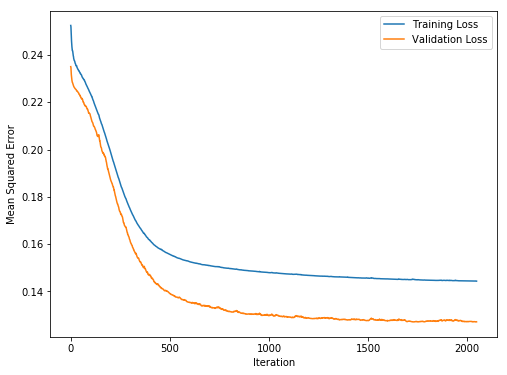

In [12]:
# plot the loss
plt.figure(0, [8,6])
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['validation'], label='Validation Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## Let's Look at Some Predictions

In [13]:
# print the first 20 targets, outputs, and target predictions
# 1 - survived, 0 - did not survive
print('targets, outputs, target predictions')
print(np.concatenate((val_targets, network.run(val_features), np.round(network.run(val_features))), axis=1)[0:20])

targets, outputs, target predictions
[[0.         0.08741894 0.        ]
 [0.         0.19947244 0.        ]
 [0.         0.08871235 0.        ]
 [1.         0.93111525 1.        ]
 [1.         0.8411099  1.        ]
 [0.         0.11850638 0.        ]
 [0.         0.08689817 0.        ]
 [1.         0.85409142 1.        ]
 [0.         0.08698608 0.        ]
 [0.         0.21037623 0.        ]
 [0.         0.20061483 0.        ]
 [1.         0.31157315 0.        ]
 [0.         0.08859113 0.        ]
 [1.         0.80445595 1.        ]
 [1.         0.68582041 1.        ]
 [0.         0.20852289 0.        ]
 [0.         0.44733581 0.        ]
 [1.         0.90145198 1.        ]
 [0.         0.11156688 0.        ]
 [0.         0.23431241 0.        ]]


In [14]:
# pull out the test data and use the model to make a prediction on it
test = titanic.loc['test']
print(test.shape)
test_features, _  = test.drop(drop_fields, axis=1), test[target_fields]

(418, 14)


In [15]:
Y_test = np.round(network.run(test_features),0).astype(int)
print(len(Y_test))
results = pd.DataFrame({'PassengerId': test['PassengerId'].values})
print(results.shape)
results['Survived'] = Y_test.reshape(-1)
display(results.head(15))

418
(418, 1)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [16]:
# save results to a CSV file
# results.to_csv('results.csv',index=False)